In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.argv=['']
del sys
os.chdir("../")

In [2]:
import matplotlib.pyplot as plt
import os
import json
import math
import torch
import logging
import numpy as np
import pandas as pd

from IPython import embed
from common import data_preprocess 
from common.utils import print_to_json, score2pred
from common.dataloader import load_dataset
from common.sliding import BatchSlidingWindow, WindowIterator
from common.config import parse_arguments, set_logger, initialize_config
from networks.mlstm import MultiLSTMEncoder
from torch import nn
%matplotlib inline

In [3]:
# train
args = parse_arguments()

# load config
config_dir = "./hypers/" if not args["load"] else args["load"]
params = initialize_config(config_dir, args)
params["clear"] = 1
params["nrows"] = None

In [4]:
data_dict = load_dataset("SMD","machine-1-4")

2021-02-18 12:57:20,979 P20265 INFO Loading machine-1-4 of SMD dataset
2021-02-18 12:57:20,980 P20265 INFO 1 files found.


In [5]:
pp = data_preprocess.preprocessor()
pp.save(params["save_path"])
data_dict = pp.normalize(data_dict,method="standard")
# data_dict = pp.discretize(data_dict,n_bins=100)
# vocab_size = pp.build_vocab(data_dict)

window_dict = data_preprocess.generate_windows(data_dict, data_hdf5_path=params["path"], **params)

2021-02-18 12:57:21,044 P20265 INFO Saving preprocessor into ./checkpoints/20210218-125720/preprocessor.pkl
2021-02-18 12:57:21,046 P20265 INFO Normalizing data
2021-02-18 12:57:21,047 P20265 INFO Generating sliding windows (size 64).
2021-02-18 12:57:21,278 P20265 INFO Train windows #: (4729, 64, 38)
2021-02-18 12:57:21,279 P20265 INFO Test windows #: (23643, 64, 38)


In [6]:
window_dict["train_windows"].shape

(4729, 64, 38)

In [7]:
train_iterator = WindowIterator(window_dict["train_windows"], batch_size=params["batch_size"], shuffle=True)
test_iterator = WindowIterator(window_dict["test_windows"], batch_size=params["batch_size"], shuffle=False)
params['in_channels'] = data_dict["dim"]

In [8]:
encoder = MultiLSTMEncoder(**params)

2021-02-18 12:57:24,246 P20265 INFO Compiling finished.


In [103]:
# batch_window = next(iter(train_iterator.loader))
# print(batch_window.shape)
# batch_window = batch_window.permute(0, 2, 1)  # b x win x ts_dim
# batch_window, y = batch_window[:, 0:-1, :], batch_window[:, -1, :]

In [9]:
# training
params["nb_steps"] = 80
encoder.fit(
            train_iterator,
            test_iterator=test_iterator.loader,
            test_labels=None,
            **params
        )
encoder.save_encoder()

2021-02-18 12:57:28,685 P20265 INFO Start training for 74 batches.
2021-02-18 12:57:29,190 P20265 INFO Epoch: 1, loss: 55.63636
2021-02-18 12:57:29,459 P20265 INFO Epoch: 2, loss: 3.32910
2021-02-18 12:57:29,743 P20265 INFO Epoch: 3, loss: 0.36063
2021-02-18 12:57:29,991 P20265 INFO Epoch: 4, loss: 0.07809
2021-02-18 12:57:30,263 P20265 INFO Epoch: 5, loss: 0.05023
2021-02-18 12:57:30,524 P20265 INFO Epoch: 6, loss: 0.04308
2021-02-18 12:57:30,775 P20265 INFO Epoch: 7, loss: 0.01421
2021-02-18 12:57:31,031 P20265 INFO Epoch: 8, loss: 0.00859
2021-02-18 12:57:31,295 P20265 INFO Epoch: 9, loss: 0.00807
2021-02-18 12:57:31,575 P20265 INFO Epoch: 10, loss: 0.00684
2021-02-18 12:57:31,831 P20265 INFO Epoch: 11, loss: 0.00507
2021-02-18 12:57:32,100 P20265 INFO Epoch: 12, loss: 0.00485
2021-02-18 12:57:32,409 P20265 INFO Epoch: 13, loss: 0.00518
2021-02-18 12:57:32,670 P20265 INFO Epoch: 14, loss: 0.00456
2021-02-18 12:57:32,935 P20265 INFO Epoch: 15, loss: 0.00458
2021-02-18 12:57:33,178 P2

In [ ]:
encoder.load_encoder()

In [28]:
# test_labels = window_dict["test_labels"][:, -1]
score_dict = encoder.score(test_iterator.loader, window_dict["test_labels"],)

2021-02-18 13:04:53,817 P20265 INFO Evaluating
2021-02-18 13:04:59,828 P20265 INFO AUC: 0.640, F1: 0.142(0.599), PS: 0.078(0.436), RC:0.789(0.954)


In [20]:
best_f1, best_theta, best_adjust, best_raw = encoder.iter_thresholds(
            score_dict["score"], score_dict["anomaly_label"], adjust=True
        )

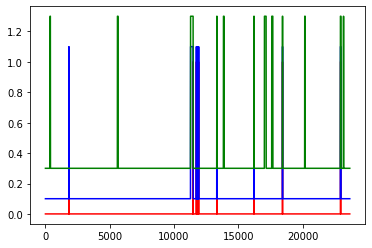

In [113]:
# x = []
plt.plot(score_dict["pred_raw"], "r")
plt.plot(score_dict["pred"]+0.1, "b")
plt.plot(anomaly_label+0.3, "g")
# plt.plot(score_dict["score"], "g")

In [11]:
# def reconstruction_loader(loader, encoder):
# train_iterator_non_shuffle = WindowIterator(window_dict["train_windows"],
#                                             batch_size=params["batch_size"], shuffle=False)
# loader = train_iterator_non_shuffle.loader

loader = test_iterator.loader
encoder = encoder.eval()
with torch.no_grad():
    recst_list = []
    real_list = []
    loss = 0
    for batch in loader:
        batch = batch.to(encoder.device)
        return_dict = encoder(batch)
        # diff = return_dict["diff"].max(dim=-1)[0] # chose the most anomaous ts
        recst = return_dict["recst"]  # chose the most anomaous ts
        recst_list.append(recst)
        real_list.append(return_dict["y"])
        loss += return_dict["loss"].item()
print(loss / len(loader))
recst_list = torch.cat(recst_list).squeeze().cpu().numpy()
real_list = torch.cat(real_list).squeeze().cpu().numpy()
diff_list = recst_list-real_list

0.0024755305208403826


In [12]:
print(recst_list.shape)
print(real_list.shape)
print(diff_list.shape)

(23643,)
(23643,)
(23643,)


In [13]:
window_dict["test_labels"].shape

(23643, 64)

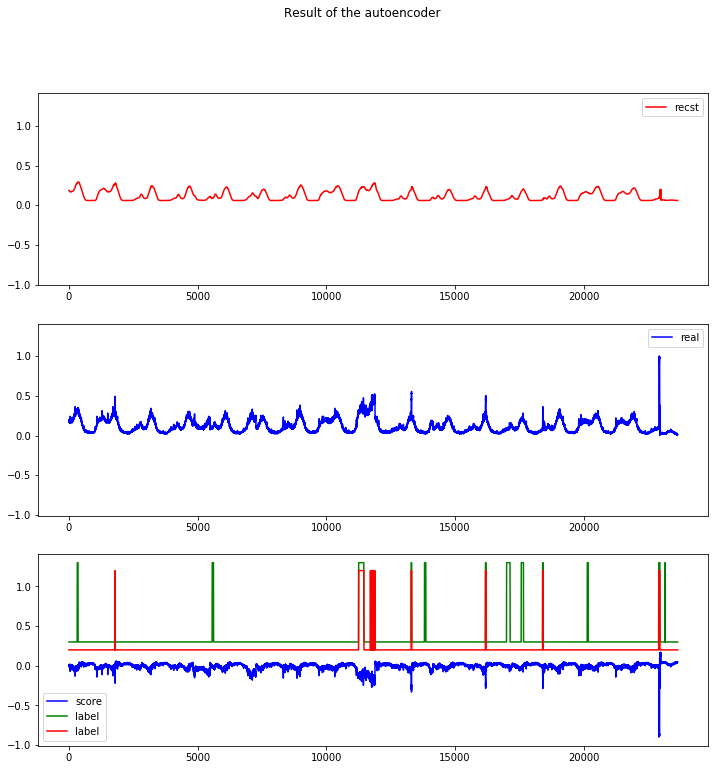

In [23]:
dims = [0,1,2]
fig, ax = plt.subplots(nrows=len(dims), sharey=True, figsize=(12,12))
i=0
# for i in range(len(dims)):
# ax[0].plot(recst, 'r', label='reconstruction')
# ax[0].legend(loc='best')
ax[0].plot(recst_list[0:-1].reshape(-1), 'r', label='recst')
ax[1].plot(real_list[0:-1].reshape(-1), 'b', label='real')
ax[2].plot(diff_list[0:-1].reshape(-1), 'b', label='score')
ax[2].plot(window_dict["test_labels"][0:, -1].reshape(-1)+0.3, 'g', label='label')
ax[2].plot(best_adjust.astype(int)+0.2, 'r', label='label') 
ax[0].legend(loc='best')
ax[1].legend(loc='best')

# ax[2].plot(recst, 'r', label='reconstruction')
# ax[2].plot(real, 'b', label='real')
# ax[2].legend(loc='best')

# ax[3].plot(diff, 'g', label='ecart')
# ax[3].legend(loc='best')

plt.legend()
plt.suptitle("Result of the autoencoder")
plt.show()

In [29]:
names=["time", "expid", "dataset", "auc", "f1", "f1a"]
df = pd.read_csv("./experiment_results.csv", sep="\t", names=names)

In [30]:
df["f1a"].map(lambda x: float(x.split("-")[1])).mean()

0.9235357142857143